In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

In [3]:
# precision_recall_curve 를 중점으로 보기!!!
# Binarizer 임계치 조절할때 편한 친구

# 데이터 준비

In [4]:
df = pd.read_csv("./data/diabetes.csv")

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.shape

(768, 9)

In [7]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

- 피처의 타입은 모두 숫자형

In [8]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

- 결측치 없어!

# 종속변수 비율 확인

In [9]:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [14]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    # Roc-AUC
    roc_auc = roc_auc_score(y_test, pred_proba)

    print("오차행렬")
    print(confusion)

    print(f"정확도 : {accuracy:.4f}, 정밀도 : {precision:.4f}, 재현율 : {recall:.4f}, F1 : {f1:.4f}, AUC : {roc_auc:.4f}")

In [15]:
def precision_recall_curve_plot(y_test = None, pred_proba_c1 = None):
    # threshold ndarray 와 이 threshold 에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    # pred_proba_c1 : 예측확률값
    
    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize = (8,6))

    threshold_boundary = thresholds.shape[0] # 기준을 thresholds으로 할것임
    plt.plot(thresholds, precisions[:threshold_boundary], linestyle = "--", label = "precision")
    plt.plot(thresholds, recalls[:threshold_boundary], label = "recall")

    # threshold 값 X축의 Scale 을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel("Threshold value")
    plt.ylabel("Precision and Recall value")
    plt.legend()
    plt.grid()
    plt.show()

# baseline 모델

In [16]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y

# 맨 마지막이 Outcome 컬럼
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size = 0.2,
    stratify = y,
    random_state = 33
)

### 임계값 조절에 대해 설명 => 로지스틱회귀모델 선택이유

In [19]:
# 로지스틱 회귀 하긋ㅂ
lr_clf1 = LogisticRegression()
lr_clf1.fit(x_train, y_train)

pred1 = lr_clf1.predict(x_test)
pred_proba1 = lr_clf1.predict_proba(x_test)[:, 1]

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 경고문 n_iter_i  100 다 돌았다~ 충분하게 돌지 못했다 이말이야~

- max_iter = 200 으로 늘려주셈

In [20]:
get_clf_eval(y_test, pred1, pred_proba1)

오차행렬
[[93  7]
 [29 25]]
정확도 : 0.7662, 정밀도 : 0.7812, 재현율 : 0.4630, F1 : 0.5814, AUC : 0.8819


- 재현율이 개판이다

- 실제 당뇨 환자를 당뇨가 아니라고 진단하면 큰 문제가 생길 수 있기 때문에 **재현율 성능**에 초점을 맞추는 방향으로 최적화

- 전체 데이터의 종속변수 비율도 음성클래스의 비율이 더 높기 때문에 재현율에 초점을 맞추는 것이 유리

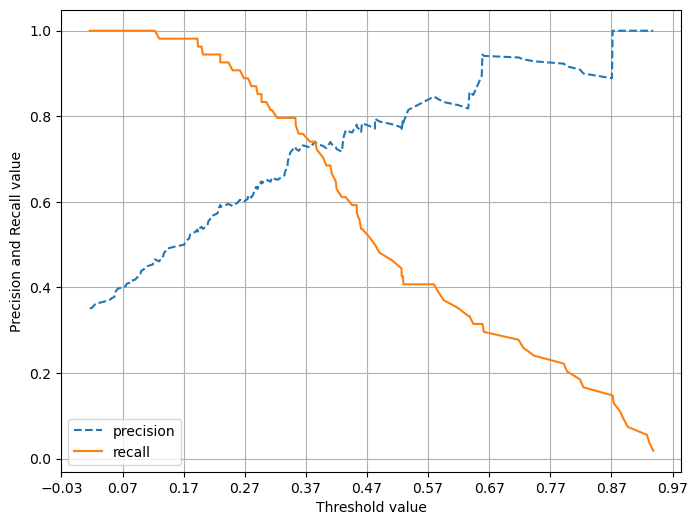

In [21]:
precision_recall_curve_plot(y_test, pred_proba1)

- 임계값이 0.37 정도에서 정밀도와 재현율이 균형을 맞출 것으로 보임

- 데이터 전처리가 추가로 필요

# 데이터 전처리

In [22]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- "Glucose"	"BloodPressure"	"SkinThickness"	"Insulin" 가 0 이라는것이 이상허다~~	

- 데이터 값의 최솟값이 0인 피처가 존재
- 포도당, 혈압, 피하지방, 인슐린, BMI가 0인 것은 납득하기 어려움

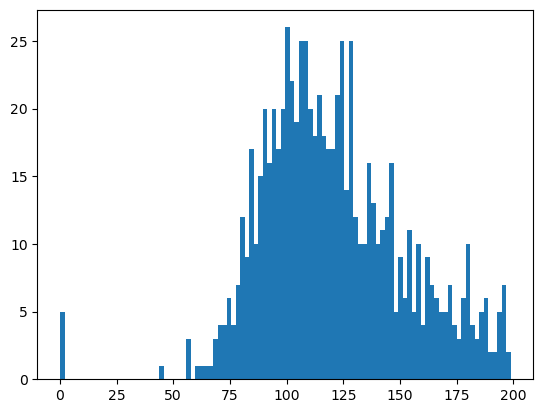

In [26]:
plt.hist(df["Glucose"], bins=100)
plt.show()

- 이 그래프를 보니 일반적인 분포를 벗어난 이상한 수치다! 를 더 잘 알수있음

In [30]:
# 0값 을 검사할 피처명 리스트 객체 설정
zero_features = ["Glucose","BloodPressure", "SkinThickness", "Insulin", "BMI"]

# 전체 데이터 건수
total_count= df["Glucose"].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수 추출하고 비율 계산
for feature in zero_features:
    zero_count = df.loc[df[feature] == 0, feature].count()
    print(f" {feature}의 0 건수는 {zero_count},비율은 {100 * zero_count/ total_count:.2f}")

 Glucose의 0 건수는 5,비율은 0.65
 BloodPressure의 0 건수는 35,비율은 4.56
 SkinThickness의 0 건수는 227,비율은 29.56
 Insulin의 0 건수는 374,비율은 48.70
 BMI의 0 건수는 11,비율은 1.43


### 시연에서는 0을 평균값으로 대체하기로 한다

- SKinThickness 와 Insulin 의 0 값 비율이 꽤 높은 편이어서 데이터 일괄 삭제 시 오히려 모델 학습에 악영향을 줄 수 있음
- 이상치를 평균값으로 대체

In [31]:
# zero_features 에 대해서 0 값을 평균값으로 대체 

mean_zero_features = df[zero_features].mean()

In [32]:
mean_zero_features

Glucose          120.894531
BloodPressure     69.105469
SkinThickness     20.536458
Insulin           79.799479
BMI               31.992578
dtype: float64

# 0 값으로 대체 해버림~~~

In [34]:
df[zero_features] = df[zero_features].replace(0, mean_zero_features)

In [35]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


# 모델 학습 방법 테스트

In [36]:
x = df.iloc[:,:-1]
y = df.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    stratify=y,
    random_state = 33
)

In [37]:
# 스케일링
ss = StandardScaler()
scaled_train = ss.fit_transform(x_train)
scaled_test = ss.transform(x_test)

In [38]:
# 로지로지
lr_clf2 = LogisticRegression()
lr_clf2.fit(scaled_train, y_train)
pred2 = lr_clf2.predict(scaled_test)
pred_proba2 = lr_clf2.predict_proba(scaled_test)[:,1]

In [39]:
get_clf_eval(y_test, pred2, pred_proba2)

오차행렬
[[95  5]
 [29 25]]
정확도 : 0.7792, 정밀도 : 0.8333, 재현율 : 0.4630, F1 : 0.5952, AUC : 0.8726


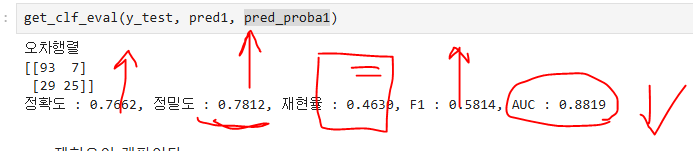

In [81]:
# 하이퍼파라미터 튜닝
logi = LogisticRegression(max_iter=200)
param = {
        # 사실은 로지회귀에 규제가 있었다...
        # 기본적으로 경사하강법을 사용
        "penalty" : ["l1", "l2", "elasticnet", None],
        "C" : [0.01,0.1,1,10,100],
        "solver" : ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]
    }

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=33)


In [96]:
gs = GridSearchCV(logi, param, scoring = "roc_auc", cv = splitter, n_jobs =-1)
gs.fit(scaled_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
550 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1193, in fit
    solver 

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=33, shuffle=True),
             estimator=LogisticRegression(max_iter=200), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='roc_auc')

In [97]:
gs.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

In [98]:
lr_clf3 = gs.best_estimator_

In [111]:
pred3 = lr_clf3.predict(scaled_test)
pred_proba3 = lr_clf3.predict_proba(scaled_test)[:, -1]

In [112]:
get_clf_eval(y_test, pred3, pred_proba3)

오차행렬
[[94  6]
 [28 26]]
정확도 : 0.7792, 정밀도 : 0.8125, 재현율 : 0.4815, F1 : 0.6047, AUC : 0.8741


# 모델 성능 평가

In [101]:
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_proba1)
fpr2, tpr2, threshold2 = roc_curve(y_test, pred_proba2)
fpr3, tpr3, threshold3 = roc_curve(y_test, pred_proba3)

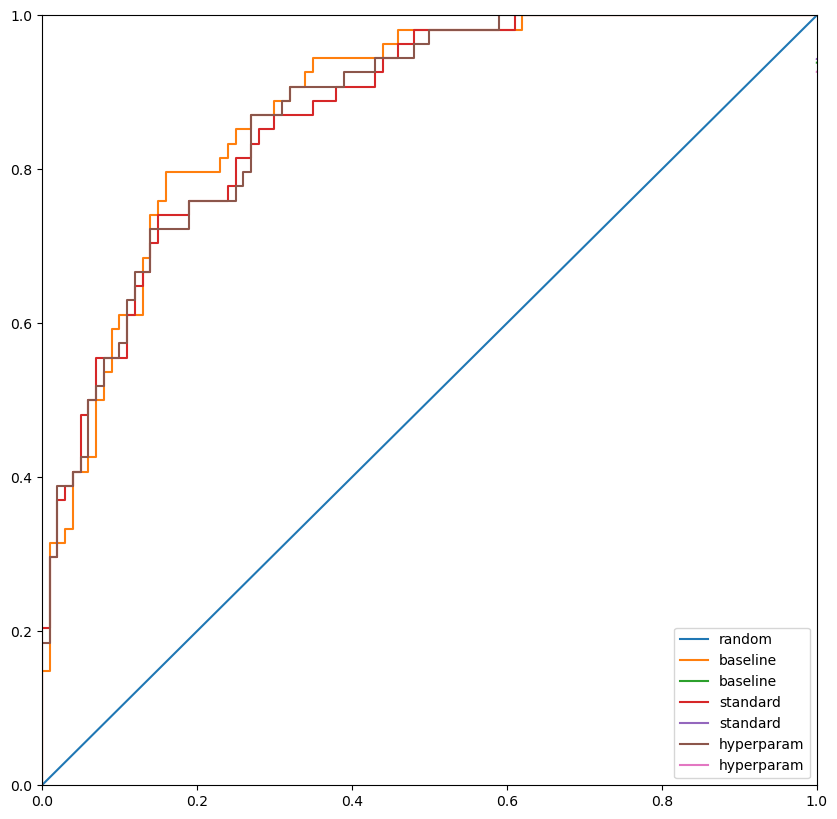

In [102]:
plt.figure(figsize = (10,10))

plt.plot([0,1], [0,1], label = "random")
plt.plot(fpr1, tpr1, threshold1, label = "baseline")
plt.plot(fpr2, tpr2, threshold2, label = "standard")
plt.plot(fpr3, tpr3, threshold3, label = "hyperparam")


plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()

In [103]:
Binarizer(threshold=0.5).fit_transform(np.arange(0.1, 1.1, 0.1).reshape(-1,1))

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

## Binarizer
임계값을 통해서 1과 0으로 바꿔주는 친구

In [120]:
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds 리스트 내의 값을 차례로 반복하면서 검증
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold= custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)

        print("임곗값:", custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)
        print("-", * 80)

In [121]:
thresholds = [0.3, 0.33, 0.36, 0.5]

get_eval_by_threshold(y_test, pred_proba3, thresholds)

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

In [110]:
# 임계값을 0.39로 설정한 Binarizer 생성
binarizer = Binarizer(threshold = 0.39)

# 위에서 구한 lr_clf의 예측확률을 Binarizer 변환
pred_th = binarizer.fit_transform(pred_proba1.reshape(-1,1))
get_clf_eval(y_test, pred_th, pred_proba1)

오차행렬
[[86 14]
 [16 38]]
정확도 : 0.8052, 정밀도 : 0.7308, 재현율 : 0.7037, F1 : 0.7170, AUC : 0.8819
